In [1]:
import gzip
import collections
from sklearn import linear_model
from sklearn import metrics
import random
import numpy as np
import string
import math
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt', encoding='utf-8'):
        if 'null' not in l:
            yield eval(l)

In [3]:
all_cloth = list(readGz("renttherunway_final_data.json.gz"))

In [4]:
all_cloth[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

In [5]:
len(all_cloth)

192462

In [12]:
for item in all_cloth:
    keys_with_spaces = list(item.keys())  # Extracting keys to modify while iterating
    for key in keys_with_spaces:
        if ' ' in key:
            new_key = key.replace(' ', '_')  # Replacing spaces with underscores
            item[new_key] = item.pop(key)  # Replace the key in the dictionary

In [13]:
all_cloth[0]

{'fit': 'fit',
 'user_id': '420272',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016',
 'bust_size': '34d',
 'rented_for': 'vacation',
 'body_type': 'hourglass'}

In [6]:
#Data cleaning:
#1: We noticed that some clothing data between user and item is incomplete
cloths_key_len = []
for item in all_cloth:
    cloths_key_len.append(len(item.keys()))


In [7]:
#Incomplete clothing data for the item if the item has less than the standard 15 variables to describe it. 
unique_values = list(set(cloths_key_len))
print(unique_values)

[12, 13, 14, 15]


In [8]:
#Cleaned Dataset 
cloth_cleaned = []
for item in all_cloth:
    if len(item.keys()) == 15:
        cloth_cleaned.append(item)
len(cloth_cleaned)

146381

In [52]:
cloth_cleaned[0]

{'fit': 'fit',
 'user_id': '420272',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016',
 'bust_size': '34d',
 'rented_for': 'vacation',
 'body_type': 'hourglass'}

In [10]:
#User item pair for recommendation:
user_dict = defaultdict(list)
for item in cloth_cleaned:
    user_dict[item['user_id']].append(item['item_id'])

In [14]:
#Different occasions of clothes
cloth_occasions = []
for item in cloth_cleaned:
    cloth_occasions.append(item['rented_for'])

In [15]:
unique_occasions = list(set(cloth_occasions))
print(unique_occasions)

['formal affair', 'party', 'date', 'work', 'other', 'wedding', 'everyday', 'vacation', 'party: cocktail']


In [17]:
len(unique_occasions)

9

# Explore Dataset

In [41]:
# count occasion
occasions_num = defaultdict(int)
for x in cloth_cleaned:
    occasions_num[x['rented_for']] += 1
occasions_num = dict(sorted(occasions_num.items(), key=lambda item: item[1]))
temp = occasions_num.pop('other')
occasions_num['other'] = temp
occasions_num.pop('party: cocktail')
print(occasions_num)

# count ratings
rating_num = defaultdict(int)
for x in cloth_cleaned:
    rating_num[int(x['rating'])] += 1
rating_num = dict(sorted(rating_num.items(), key=lambda item: item[0]))
print(rating_num)

{'vacation': 3238, 'date': 5929, 'work': 12124, 'everyday': 13263, 'party': 27198, 'formal affair': 30496, 'wedding': 42622, 'other': 11510}
{2: 783, 4: 2205, 6: 8341, 8: 40761, 10: 94291}


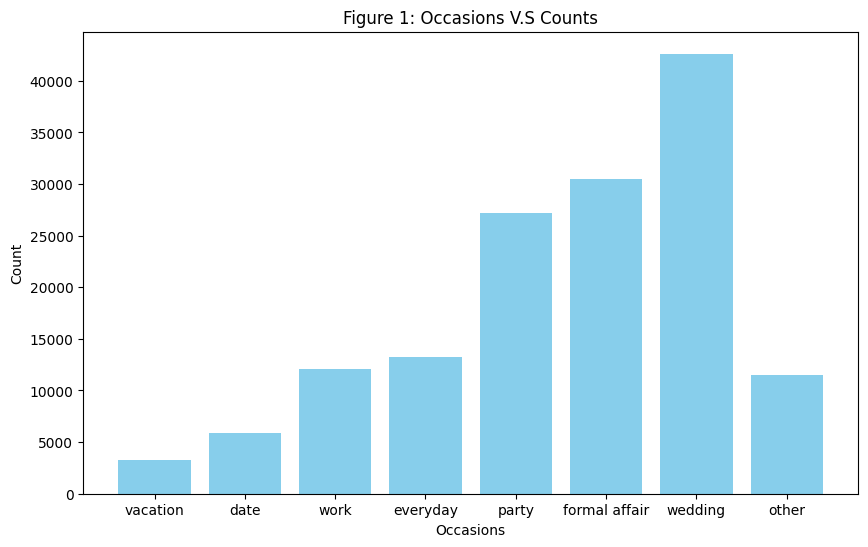

In [43]:
labels = list(occasions_num.keys())
values = list(occasions_num.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.ylabel('Count')
plt.xlabel('Occasions')
plt.title('Figure 1: Occasions Distribution')

plt.show()

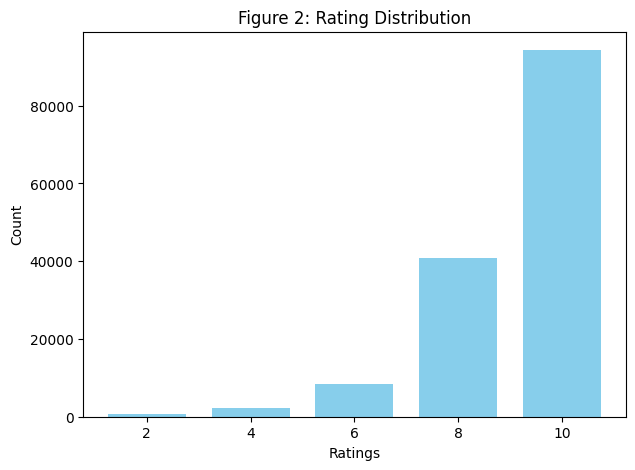

In [51]:
labels = list(rating_num.keys())
values = list(rating_num.values())

plt.figure(figsize=(7, 5))
plt.bar(labels, values, color='skyblue', width=1.5)
plt.ylabel('Count')
plt.xlabel('Ratings')
plt.title('Figure 2: Rating Distribution')


plt.show()

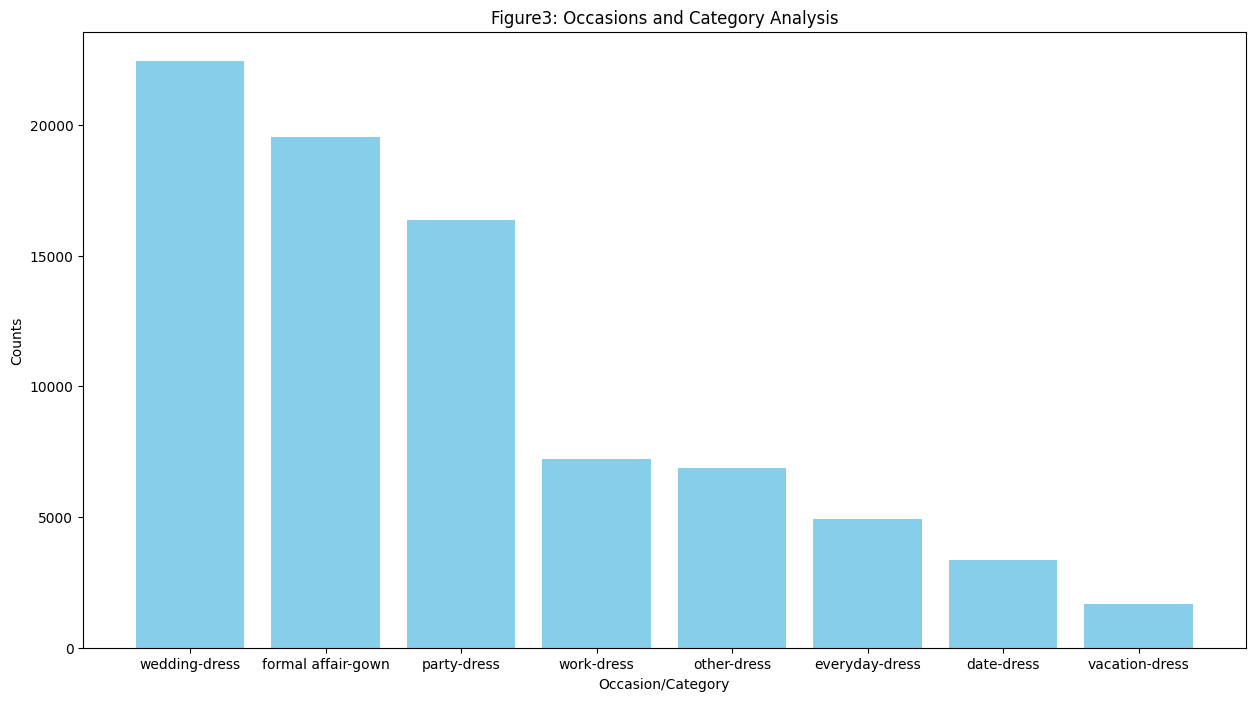

In [69]:
rented_for_category_counts = {}

for x in cloth_cleaned:
    rented_for = x['rented_for']
    category = x['category']
    
    # Creating a combined key for rented_for and category
    combined_key = f"{rented_for}-{category}"
    
    rented_for_category_counts[combined_key] = rented_for_category_counts.get(combined_key, 0) + 1

sorted_counts = dict(sorted(rented_for_category_counts.items(), key=lambda item: item[1], reverse=True))
unique = []
unique_occ_cat_count = {}
for x in sorted_counts:
    occ =  x.split('-')[0]
    if occ not in unique:
        unique.append(occ)
        unique_occ_cat_count[x] = sorted_counts[x]
unique_occ_cat_count.pop('party: cocktail-dress')

plt.figure(figsize=(15, 8))
plt.bar(unique_occ_cat_count.keys(), unique_occ_cat_count.values(), color='skyblue')
plt.title('Figure3: Occasions and Category Analysis')
plt.xlabel('Occasion/Category')
plt.ylabel('Counts')
plt.show()